# 从0——1开始手撕一个简单的神经网络
### 本文将教你如何手撕一个神经网络？
![](https://ai-studio-static-online.cdn.bcebos.com/67c7bd66083c4cb3878da4d5e8dac162abeaa92d52024afd875fdffcc10602bc)

## 咳咳。。。。不是这样手撕！下面进入正题。
### 本文前半部分主要翻译自[Implementing a Neural Network from Scratch in Python – An Introduction](http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/)

### 为什么要从0到1手撕一个神经网络
>#### 在本文中，我们将从头开始实现一个简单的三层神经网络。我们不会推导出所需要掌握的所有数学公式，但我将尝试对我们正在做的事情给出直观的解释，并将指向参考资料以阅读详细信息。在这篇文章中，我假设你熟悉微积分和机器学习的基本概念，例如，你知道什么是分类和正则化。理想情况下，你也知道一些优化技术，如梯度下降工作。但是，即使你不熟悉上述任何一个，这篇文章仍然可能是有趣的。但为什么要从头开始实现神经网络呢？即使你计划使用飞桨paddlepaddle这样优秀的深度学习框架,在未来，至少一次从头开始实现一个网络是非常有价值的练习。它有助于你了解神经网络>是如何工作的，这对设计有效的模型至关重要。这里的代码示例虽然执行效率不高。但是相对来说比较容易理解。同时也让你明白，为什么有必要学习深度学习框架飞桨paddlepaddle。

## 导入所需要的库

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## 生成数据集

> #### 首先我们生成一个可以操作的数据集，幸运的是，scikit-learn提供了一些有用的数据集生成器，所以我们不需要自己写代码来生成数据集，只需使用make_moons这个函数就可以。

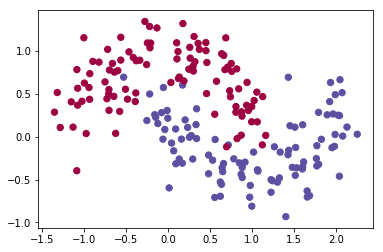

In [2]:

np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

>#### 我们生成的数据集中有两种类型的数据，分别用红点和蓝点标识了出来。你可以将蓝点视为男性患者，将红点视为女性患者，并且将x轴和y轴视为医疗方式。我们的目标是训练一个机器学习分类器，让它在x、y坐标系下预测正确的类别（男性或者女性）。需要注意的是这些数据不能被线性分割，我们无法画出一条直线将这两种类型的数据分开，这意味着线性分类器（比如Logistic回归）将无法拟合这些数据，除非你手工设计的非线性特征（如多项式），为给定的数据集工作良好。事实上，这就是神经网络主要的优点之一，你不必担心特征工程，神经网络的隐藏层将会为你学习特征。

## Logistic回归

>#### 为了证明这一点，让我们训练一个Logistic回归分类器。这个分类器的输入是坐标x、y，它的输出是预测的数据类型（0或1）。为了方便，我们使用scikit-learn中的Logistic Regression类。

In [3]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
# Helper function to plot a decision boundary.
# 生成下面的等高线图
def plot_decision_boundary(pred_func):
    # 设置最小值和最大值并给它一些填充
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # 生成点间距为h的网格
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # 预测整个gid的函数值

    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

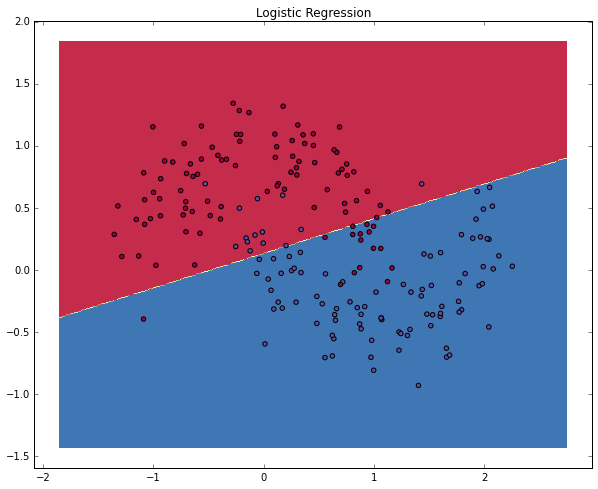

In [ ]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

上图显示了Logistic回归分类器学习的决策边界，它用直线尽可能地把数据分开了，但是并没有捕获数据的月牙形状。

## 训练一个神经网络

现在让我们搭建一个3层的神经网络，其中包含1个输入层，1个隐藏层以及1个输出层。输出层的节点数取决于我们的数据的维度，也就是2；类似地，输出层的节点数取决于我们有多少类数据，这里也是2（因为我们只有两类数据，所以实际上可以只有一个输出节点，输出0或1，但是有两个输出节点会使得以后有多类数据的时候神经网络更容易扩展）。神经网络的输入是x、y坐标，而输出是两个概率，一个是类型为0（女性患者）的概率，另一个是类型为1（男性患者）的概率。这个神经网络看起来就像下面这样：



<img src='https://ai-studio-static-online.cdn.bcebos.com/e02f76bc5b7a41feaef40e9e23a4a6c0aa15c10dab1f4f94b81aa17b5fe76e70' style='width: 50%'/>

我们可以自己选择隐藏层的维度（节点数量），隐藏层节点的数量越多，我们能够适应的功能就越复杂。但是高维度总是伴随着高成本。如果节点数量很多，首先，为了预测结果以及学习神经网络参数，就需要进行大量的计算；其次，更多的参数数量（译者注：隐藏层的参数量是由该层节点数和前一层的节点数决定的）意味着更容易造成对数据的过度拟合。

那么该如何选择隐藏层的节点数呢？尽管有一些通用指南和建议，但是隐藏层的节点数通常取决于你要解决的特定的问题，与其说节点数的选择是一门科学，不如说它是一门艺术。我们稍后会探究隐藏层节点的数量问题，并观察它是如何影响神经网络的输出的。

我们还需要为隐藏层选择一个激活函数，激活函数用来将该层的输入转换成输出。非线性激活函数能够使我们拟合非线性数据。常用的激活函数有tanh、sigmoid以及RELUs，在这里我们使用tanh，因为它在很多场景中都表现得很好。这些函数都有一个很棒的特性，那就是它们的导数都能用它们本身表示，比如，tanh(x)的导数是1 −tanh^2(x)，这非常有用，因为我们只要计算tanh(x)的值一次，就可以在对tanh(x)求导的时候重复使用它。

因为我们想要让神经网络输出概率，所以输出层的激活函数我们使用softmax，它可以简单地把原始数值转换成概率。如果你对逻辑函数很熟悉，那么你可以将softmax看作是逻辑函数在多类型中的一般化应用。

### 神经网络如何做出预测

我们的神经网络利用正向传播来做出预测，所谓正向传播，就是指一组矩阵的相乘以及我们之前提到的激活函数的应用。假设 $x$ 是对神经网络的二维输入，那么我们按照如下步骤计算我们的预测结果 $\hat{y}$ （维度也是2）：

$$
\begin{aligned}
z_1 & = xW_1 + b_1 \\
a_1 & = \tanh(z_1) \\
z_2 & = a_1W_2 + b_2 \\
a_2 & = \hat{y} = \mathrm{softmax}(z_2)
\end{aligned}
$$

$z_i是第层的输入，$a_i是第$i层使用激活函数计算后的输出， $W_1, b_1, W_2, b_2$是我们这个神经网络的参数，是需要通过训练
数据来让神经网络学习的。你可以将他们看作是在神经网络的不同层之间转换数据的矩阵。观察上面的矩阵乘法运算，我
们可以算出这些矩阵的维度，如果隐藏层有500个节点，那么$W_1 \in \mathbb{R}^{2\times500}$, $b_1 \in \mathbb{R}^{500}$, $W_2 \in \mathbb{R}^{500\times2}$, $b_2 \in \mathbb{R}^{2}$.现在
你应该知道为什么如果我们增加隐藏层的节点数量，我们就会有更多的参数了。


### 学习参数

为神经网络学习参数意味着在训练数据上寻找最佳参数 ($W_1, b_1, W_2, b_2$) 以此达到使错误最小化的目的。但是我们应该如何定义“错误”呢？我们将衡量错误的函数称为损失函数（loss function）。对于softmax输出来说，一个常用的选择是分类交叉熵损失 [cross-entropy loss](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_error_function_and_logistic_regression). 如果我们有N个训练样本，以及 $C$ 个输出类别，那么我们的预测结果 $\hat{y}$ 相对于真值标签 $y$ 的损失是这样定义的：

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$



这个公式看起来复杂，其实它做的事情就是总结训练样本，如果预测错了类型，就增加损失（译者注：粗体部分的原文如下：sum over our training examples and add to the loss if we predicted the incorrect class. 我不确定粗体部分这样翻译是否合适，如果有网友有更好的翻译欢迎指正）。 $y$ （正确的标签）和 $\hat{y}$ （我们的预测值）的数值相差越大，我们的损失就越大。通过寻找使损失最小化的参数，我们可以最大限度地提高训练数据的似然。

我们可以用梯度下降法来寻找损失函数的最小值。我会用固定的学习率实现一个最普通版本的梯度下降法，也称为批量梯度下降法，它的变化版本比如随机梯度下降法和小批量梯度下降法在实践中通常表现得更好，所以如果你对此要求严格，那么你一定会想要使用它们，最好随着时间的推移再配合以学习率衰减。
作为输入，梯度下降法需要计算损失函数对于参数的梯度（导数向量）： $\frac{\partial{L}}{\partial{W_1}}$, $\frac{\partial{L}}{\partial{b_1}}$, $\frac{\partial{L}}{\partial{W_2}}$, $\frac{\partial{L}}{\partial{b_2}}$. 我们利用著名的反向传播算法来计算这些梯度，从输出开始用反向传播计算梯度会很高效。对于反向传播的工作原理，我不会深入讲解其细节，但是网上有很多出色的解释
下面的公式会帮助我们应用反向传播（这里请相信我）：

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

### 实现

现在我们已经准备好实现一个神经网络了，我们为梯度下降定义一些变量和参数：

In [5]:
num_examples = len(X) # 训练集大小
nn_input_dim = 2 # 输入层维度
nn_output_dim = 2 # 输出层维数

# 梯度下降参数（我手工挑选）
epsilon = 0.01 # 梯度下降学习率
reg_lambda = 0.01 # 正则化强度

首先我们实现之前定义的损失函数，我们用这个损失函数来衡量模型的工作成果是否令人满意。

In [6]:
# Helper函数来评估数据集上的总损失
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 向前传播来计算我们的预测
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # 计算损失
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # 将调节项添加到损失（可选）
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

我们还实现了一个函数用来帮助我们计算神经网络的输出，就像我们之前定义的那样，在函数内部进行正向传播，然后返回概率最高的那个类别。

In [7]:
# 用于预测输出的辅助函数（0或1）
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # 正向传播
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

最后，这个函数用来训练神经网络，它利用我们之前提到的反向传播导数来实现批量梯度下降。

In [8]:
# 此函数学习神经网络的参数并返回模型。
# - nn_hdim: 隐藏层中的节点数
# - num_passes: 通过梯度下降训练数据的次数
# - print_loss: 如果为真，则每1000次打印一次损失
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # 将参数初始化为随机值。我们需要学习这些。
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # 这就是我们最后的返回值
    model = {}
    
    # 梯度下降的批处理。
    for i in range(0, num_passes):

        # 正向传播
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # 反向传播
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # 添加正则化项（b1和b2没有正则化项）
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # 梯度下降参数更新
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # 为模型指定新参数
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # 可选择打印损失。
        # 因为使用整个数据集，所以我们不要打印太多。
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### 隐藏层节点数为3的神经网络

当我们训练一个隐藏层节点数为3的神经网络时，让我们看看会发生什么。


Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068888
Loss after iteration 3000: 0.070752
Loss after iteration 4000: 0.070748
Loss after iteration 5000: 0.070751
Loss after iteration 6000: 0.070754
Loss after iteration 7000: 0.070756
Loss after iteration 8000: 0.070757
Loss after iteration 9000: 0.070758
Loss after iteration 10000: 0.070758
Loss after iteration 11000: 0.070758
Loss after iteration 12000: 0.070758
Loss after iteration 13000: 0.070758
Loss after iteration 14000: 0.070758
Loss after iteration 15000: 0.070758
Loss after iteration 16000: 0.070758
Loss after iteration 17000: 0.070758
Loss after iteration 18000: 0.070758
Loss after iteration 19000: 0.070758


Text(0.5,1,'Decision Boundary for hidden layer size 3')

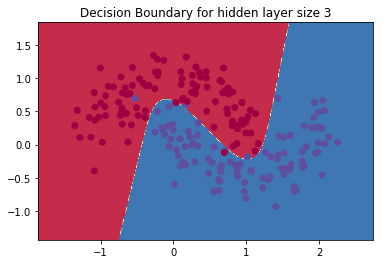

In [9]:
# 建立一个具有三维隐藏层的模型
model = build_model(3, print_loss=True)

# 绘制决策边界
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

### 666！这看起来很棒。我们的神经网络发现的决策边界能够成功地区分数据类别。

# 改变隐藏层的大小

在上面的例子中，我们选择了有三个节点的隐藏层，现在让我们看看改变隐藏层的大小会如何影响最终的结果。


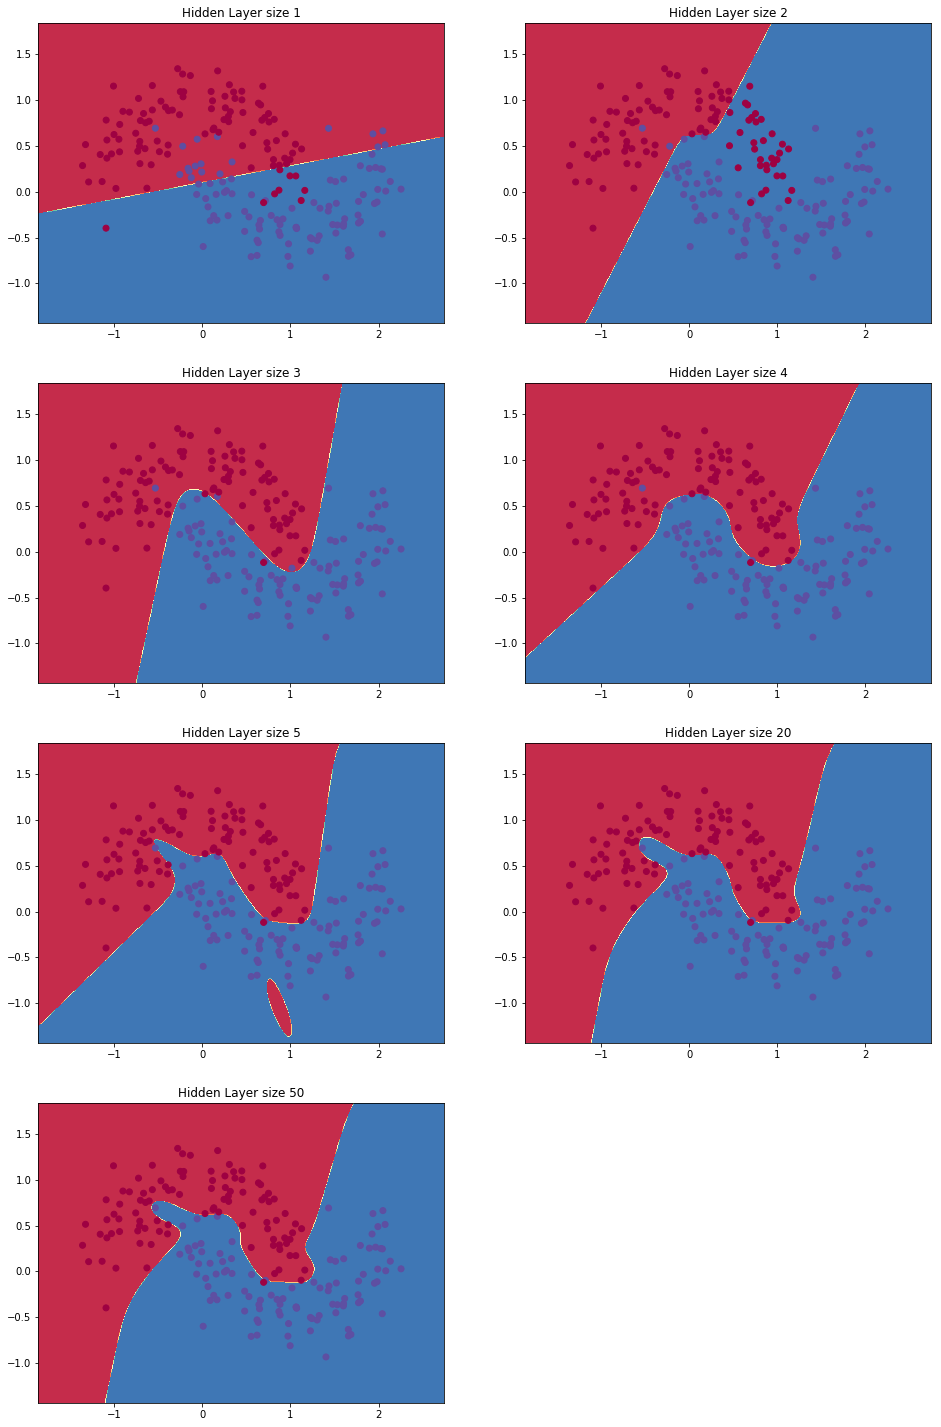

In [10]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

### 我们可以看到低维度的隐藏层可以很好地捕获数据的大致边界，而高维度的隐藏层则更易出现过度拟合。正如我们期待的那样，它们“记住”了数据并适应了数据的大致形状。如果我们接下来在一个独立的测试集上评估我们的模型（事实上你也应该这么做），低维度的隐藏层会表现得更好，因为它们更一般化。我们可以利用更高强度的正则化来抵消过度拟合，但是为隐藏层选择一个正确的尺寸则是比较“经济”的解决办法。

# 走完了整个流程，是不是觉得这样很麻烦，网络如果只有两三层那还好说，如果有几十层，几百层呢？显然这样做会增加我们实现这个项目的负担和成本，开发效率就会大大降低，所以就有了深度学习和深度学习框架，我们引入了基于产业实践的国产深度学习框架飞桨Paddlepaddle，飞桨框架封装了很多高层的API,这样就不用考虑数学方面的细节，这样就极大的提高了开发效率和工程开发周期。如何运用飞桨实现一个项目呢？具体请看文档：[飞桨paddlepaddle2.0模型开发文档教程](https://www.paddlepaddle.org.cn/documentation/docs/zh/2.0-rc1/guides/02_paddle2.0_develop/index_cn.html)

### 举一个简单例子，实践一个手写数字识别任务

### 导入飞桨

In [5]:
import paddle

### 数据加载
通过Sequential将一层一层的网络结构组建起来。需要先对数据进行Flatten操作，将[1,28, 28]形状的图片数据改变形状为[1,784]。

In [6]:
from paddle.vision.transforms import ToTensor

train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=ToTensor())
val_dataset =  paddle.vision.datasets.MNIST(mode='test', transform=ToTensor())


Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/train-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/train-labels-idx1-ubyte.gz 
Begin to download
........
Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-images-idx3-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-images-idx3-ubyte.gz 
Begin to download

Download finished
Cache file /home/aistudio/.cache/paddle/dataset/mnist/t10k-labels-idx1-ubyte.gz not found, downloading https://dataset.bj.bcebos.com/mnist/t10k-labels-idx1-ubyte.gz 
Begin to download
..
Download finished


### 模型搭建

In [7]:
mnist = paddle.nn.Sequential(
    paddle.nn.Flatten(),
    paddle.nn.Linear(784, 512),
    paddle.nn.ReLU(),
    paddle.nn.Dropout(0.2),
    paddle.nn.Linear(512, 10)
)

### 模型训练

In [8]:
# 预计模型结构生成模型实例，便于进行后续的配置、训练和验证
model = paddle.Model(mnist)

# 模型训练相关配置，准备损失计算方法，优化器和精度计算方法
model.prepare(paddle.optimizer.Adam(parameters=mnist.parameters()),
              paddle.nn.CrossEntropyLoss(),
              paddle.metric.Accuracy())

# 开始模型训练
model.fit(train_dataset,
          epochs=5,
          batch_size=64,
          verbose=1)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/distributed/parallel.py:119: UserWarning: Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything.
  "Currently not a parallel execution environment, `paddle.distributed.init_parallel_env` will not do anything."
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:77: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return (isinstance(seq, collections.Sequence) and


The loss value printed in the log is the current step, and the metric is the average value of previous step.
Epoch 1/5
step 938/938 [==============================] - loss: 0.0996 - acc: 0.9284 - 24ms/step        
Epoch 2/5
step 938/938 [==============================] - loss: 0.0944 - acc: 0.9682 - 24ms/step         
Epoch 3/5
step 938/938 [==============================] - loss: 0.0297 - acc: 0.9776 - 24ms/step        
Epoch 4/5
step 938/938 [==============================] - loss: 0.0041 - acc: 0.9828 - 24ms/step         
Epoch 5/5
step 938/938 [==============================] - loss: 0.0872 - acc: 0.9868 - 24ms/step         


### 模型评估

In [9]:
model.evaluate(val_dataset, verbose=0)

{'loss': [4.8875927e-06], 'acc': 0.9797}

### 至此我们可以知道如何通过飞桨的几个简单API来快速完成一个深度学习任务，是不是相对来说很简单，不用考虑太多的数学细节，就可以搭建神经网络，实现自己的项目

# 练习


为了对代码更熟悉，你可以尝试做下面这些事：

1. 用小批量梯度下降法，而不是批量梯度下降法来训练神经网络。在实践中，小批量梯度下降法通常会表现得更好。
2. 我们在梯度下降时用了固定的学习率 $\epsilon$ ， 你可以为梯度下降的学习率创建一个衰减过程
3. 我们在隐藏层使用的激活函数是$\tanh$ 用其他的激活函数实践一下（有一些在上面提到了）。注意：改变激活函数也就意味着要改变反向传播导数。
4. 把神经网络的输出类别从2增加到3。为此你需要生成一个类似的数据集。
5. 将神经网络扩展到4层。在神经网络的层数上面做一下实践。增加另外一个隐藏层意味着你不仅要调整正向传播的代码，还要调整反向传播的代码。
6. 运用飞桨框架，实现一个三层的神经网络，完成本文教程例子。
